# Comprehensive Data Preprocessing Pipeline
## Heart Risk Prediction Project - Week 1-2

**Objective:** Complete data preprocessing pipeline based on comprehensive EDA findings.

**Input:** Raw heart_data.csv (42,377 rows × 26 columns)  
**Output:** Model-ready datasets (train/test) with proper preprocessing  

**Processing Pipeline Based on EDA:**
1. **Feature Engineering**: BMI creation, age groups, lifestyle scores
2. **Feature Selection**: Remove target leakage, country, redundant features
3. **Missing Value Treatment**: Median/mode imputation based on feature type
4. **Outlier Handling**: IQR-based capping for extreme values
5. **Encoding**: One-hot for categorical, label encoding where appropriate
6. **Scaling**: StandardScaler for numerical features
7. **Train/Test Split**: Stratified split maintaining class distribution

**Critical EDA Findings:**
- ⚠️ Target leakage: 'health' feature excluded (88.6% predictive accuracy)
- 📊 24 clean predictor features identified  
- 🎯 Target: `hltprhc` - significant class imbalance (7.9:1 ratio)
- 🔍 Missing data: 0.3% overall, specific patterns in lifestyle features
- 📈 Key features: BMI, age, lifestyle, social factors
- ⚖️ Outliers detected in height, weight, age variables

In [11]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from pathlib import Path
from datetime import datetime
import joblib
import json

# Preprocessing and encoding
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("✅ Libraries imported successfully")
print(f"📊 Pandas version: {pd.__version__}")
print(f"📈 Matplotlib version: {plt.matplotlib.__version__}")
print(f"🎨 Seaborn version: {sns.__version__}")
print(f"🔧 Processing date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

✅ Libraries imported successfully
📊 Pandas version: 2.3.3
📈 Matplotlib version: 3.10.8
🎨 Seaborn version: 0.13.2
🔧 Processing date: 2026-01-05 18:27


In [2]:
# Load raw dataset and initial assessment
print("📥 LOADING RAW DATASET")
print("=" * 50)

data_path = Path("../data/raw/heart_data.csv")
df_raw = pd.read_csv(data_path)

print(f"✅ Raw dataset loaded: {df_raw.shape}")
print(f"💾 Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Create working copy
df = df_raw.copy()

# Initial data overview
print(f"\n📊 INITIAL DATA OVERVIEW:")
print(f"Shape: {df.shape}")
print(f"Data types: {df.dtypes.value_counts().to_dict()}")
print(f"Missing values: {df.isnull().sum().sum()} ({(df.isnull().sum().sum()/(len(df)*len(df.columns))*100):.2f}%)")

# Display first few rows
print(f"\n👀 SAMPLE DATA:")
display(df.head(3))

# Check for target variable
if 'hltprhc' in df.columns:
    target_dist = df['hltprhc'].value_counts()
    print(f"\n🎯 TARGET DISTRIBUTION (hltprhc):")
    for value, count in target_dist.items():
        pct = (count / len(df)) * 100
        print(f"  {value}: {count} ({pct:.1f}%)")
    print(f"  Class imbalance ratio: {target_dist.max()/target_dist.min():.1f}:1")
else:
    print(f"⚠️ Target variable 'hltprhc' not found!")
    print(f"Available columns: {list(df.columns)}")

📥 LOADING RAW DATASET
✅ Raw dataset loaded: (42377, 26)
💾 Memory usage: 10.14 MB

📊 INITIAL DATA OVERVIEW:
Shape: (42377, 26)
Data types: {dtype('float64'): 17, dtype('int64'): 8, dtype('O'): 1}
Missing values: 2757 (0.25%)

👀 SAMPLE DATA:


,Unnamed: 0,cntry,happy,sclmeet,inprdsc,health,ctrlife,etfruit,eatveg,dosprt,cgtsmok,alcfreq,height,weighta,fltdpr,flteeff,slprl,wrhpp,fltlnl,enjlf,fltsd,hltprhc,hltprhb,hltprdi,gndr,paccnois
0,1,AT,8.0,4.0,1.0,3.0,8.0,3.0,3.0,3.0,4.0,3.0,178,90,1.0,1.0,1.0,3.0,1.0,3.0,1.0,0,1,0,1,0
1,2,AT,9.0,7.0,4.0,2.0,8.0,1.0,1.0,5.0,5.0,3.0,168,74,2.0,2.0,3.0,3.0,3.0,4.0,2.0,1,0,0,2,0
2,3,AT,9.0,4.0,4.0,1.0,9.0,4.0,3.0,3.0,1.0,4.0,180,95,2.0,2.0,3.0,3.0,1.0,3.0,1.0,0,0,0,2,0



🎯 TARGET DISTRIBUTION (hltprhc):
  0: 37582 (88.7%)
  1: 4795 (11.3%)
  Class imbalance ratio: 7.8:1


---

## 🧬 Feature Engineering

Create new features based on domain knowledge and EDA insights.

In [3]:
# Feature Engineering: BMI Creation and Domain-based Features
print("🧬 FEATURE ENGINEERING")
print("=" * 50)

# 1. Create BMI feature from weight and height
if 'weighta' in df.columns and 'height' in df.columns:
    print("Creating BMI from weight and height...")
    
    # Check data quality before BMI calculation
    print(f"Weight range: {df['weighta'].min():.1f} - {df['weighta'].max():.1f} kg")
    print(f"Height range: {df['height'].min():.1f} - {df['height'].max():.1f} cm")
    
    # Create BMI: weight(kg) / (height(m))^2
    df['bmi'] = df['weighta'] / ((df['height'] / 100) ** 2)
    
    # Handle extreme BMI values (likely data errors)
    valid_bmi_mask = (df['bmi'] >= 10) & (df['bmi'] <= 60)  # Reasonable BMI range
    df.loc[~valid_bmi_mask, 'bmi'] = np.nan
    
    print(f"✅ BMI created: range {df['bmi'].min():.1f} - {df['bmi'].max():.1f}")
    print(f"Missing BMI values: {df['bmi'].isnull().sum()} ({(df['bmi'].isnull().sum()/len(df)*100):.2f}%)")
else:
    print("⚠️ Weight or height columns not found for BMI calculation")

# 2. Create lifestyle health score
lifestyle_cols = ['etfruit', 'eatveg', 'dosprt']
available_lifestyle = [col for col in lifestyle_cols if col in df.columns]

if len(available_lifestyle) >= 2:
    print(f"\nCreating lifestyle score from: {available_lifestyle}")
    df['lifestyle_score'] = 0
    for col in available_lifestyle:
        # Normalize to 0-1 scale (higher = healthier)
        col_normalized = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
        df['lifestyle_score'] += col_normalized
    
    df['lifestyle_score'] = df['lifestyle_score'] / len(available_lifestyle)
    print(f"✅ Lifestyle score range: {df['lifestyle_score'].min():.2f} - {df['lifestyle_score'].max():.2f}")

# 3. Create social connectedness score
social_cols = ['sclmeet', 'fltlnl']
available_social = [col for col in social_cols if col in df.columns]

if len(available_social) >= 1:
    print(f"\nCreating social score from: {available_social}")
    df['social_score'] = 0
    for col in available_social:
        col_normalized = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
        df['social_score'] += col_normalized
    
    df['social_score'] = df['social_score'] / len(available_social)
    print(f"✅ Social score range: {df['social_score'].min():.2f} - {df['social_score'].max():.2f}")

# 4. Create mental health score
mental_cols = ['happy', 'fltdpr', 'flteeff', 'enjlf']
available_mental = [col for col in mental_cols if col in df.columns]

if len(available_mental) >= 2:
    print(f"\nCreating mental health score from: {available_mental}")
    df['mental_health_score'] = 0
    for col in available_mental:
        col_normalized = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
        df['mental_health_score'] += col_normalized
    
    df['mental_health_score'] = df['mental_health_score'] / len(available_mental)
    print(f"✅ Mental health score range: {df['mental_health_score'].min():.2f} - {df['mental_health_score'].max():.2f}")

print(f"\n📊 After feature engineering: {df.shape}")
print(f"New features created: {df.shape[1] - df_raw.shape[1]}")

🧬 FEATURE ENGINEERING
Creating BMI from weight and height...
Weight range: 37.0 - 145.0 kg
Height range: 120.0 - 210.0 cm
✅ BMI created: range 16.0 - 40.0
Missing BMI values: 0 (0.00%)

Creating lifestyle score from: ['etfruit', 'eatveg', 'dosprt']
✅ Lifestyle score range: 0.00 - 1.00

Creating social score from: ['sclmeet', 'fltlnl']
✅ Social score range: 0.00 - 1.00

Creating mental health score from: ['happy', 'fltdpr', 'flteeff', 'enjlf']
✅ Mental health score range: 0.00 - 1.00

📊 After feature engineering: (42377, 30)
New features created: 4


---

## 🗑️ Feature Selection and Data Cleaning

Remove problematic features based on EDA findings and requirements.

In [4]:
# Remove features based on EDA findings and requirements
print("🗑️ FEATURE SELECTION AND CLEANING")
print("=" * 50)

features_to_remove = []

# 1. Remove target leakage feature
if 'health' in df.columns:
    features_to_remove.append('health')
    print("✅ Will remove 'health' - target leakage confirmed (88.6% accuracy)")

# 2. Remove country feature as requested
if 'cntry' in df.columns:
    features_to_remove.append('cntry')
    print(f"✅ Will remove 'cntry' - {df['cntry'].nunique()} countries")

# 3. Remove alternative target variables
alternative_targets = ['hltprhb', 'hltprdi']
for target in alternative_targets:
    if target in df.columns:
        features_to_remove.append(target)
        print(f"✅ Will remove '{target}' - alternative target variable")

# 4. Remove original weight and height (replaced by BMI)
if 'bmi' in df.columns:
    for col in ['weighta', 'height']:
        if col in df.columns:
            features_to_remove.append(col)
    print("✅ Will remove 'weighta' and 'height' - replaced by BMI")

# 5. Remove ID column if exists
id_cols = ['Unnamed: 0', 'id', 'ID']
for col in id_cols:
    if col in df.columns:
        features_to_remove.append(col)
        print(f"✅ Will remove '{col}' - ID column")

# Perform removal
if features_to_remove:
    existing_features = [f for f in features_to_remove if f in df.columns]
    df = df.drop(columns=existing_features)
    print(f"\n✅ Removed {len(existing_features)} features: {existing_features}")

print(f"\n📊 CLEANED DATASET:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Verify target variable exists
if 'hltprhc' in df.columns:
    print(f"✅ Target variable 'hltprhc' confirmed")
    predictor_features = [col for col in df.columns if col != 'hltprhc']
    print(f"📊 Predictor features: {len(predictor_features)}")
else:
    print(f"❌ Target variable 'hltprhc' missing!")

# Show feature types
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target from feature lists
if 'hltprhc' in numerical_features:
    numerical_features.remove('hltprhc')
if 'hltprhc' in categorical_features:
    categorical_features.remove('hltprhc')

print(f"\n📊 FEATURE TYPES:")
print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

🗑️ FEATURE SELECTION AND CLEANING
✅ Will remove 'health' - target leakage confirmed (88.6% accuracy)
✅ Will remove 'cntry' - 28 countries
✅ Will remove 'hltprhb' - alternative target variable
✅ Will remove 'hltprdi' - alternative target variable
✅ Will remove 'weighta' and 'height' - replaced by BMI
✅ Will remove 'Unnamed: 0' - ID column

✅ Removed 7 features: ['health', 'cntry', 'hltprhb', 'hltprdi', 'weighta', 'height', 'Unnamed: 0']

📊 CLEANED DATASET:
Shape: (42377, 23)
Columns: ['happy', 'sclmeet', 'inprdsc', 'ctrlife', 'etfruit', 'eatveg', 'dosprt', 'cgtsmok', 'alcfreq', 'fltdpr', 'flteeff', 'slprl', 'wrhpp', 'fltlnl', 'enjlf', 'fltsd', 'hltprhc', 'gndr', 'paccnois', 'bmi', 'lifestyle_score', 'social_score', 'mental_health_score']
✅ Target variable 'hltprhc' confirmed
📊 Predictor features: 22

📊 FEATURE TYPES:
Numerical features: 22
Categorical features: 0


---

## 🔍 Missing Value Analysis and Treatment

🔍 MISSING VALUE ANALYSIS AND TREATMENT
Columns with missing values (19 total):


,Column,Missing_Count,Missing_Percentage,Data_Type
lifestyle_score,lifestyle_score,590,1.39,float64
mental_health_score,mental_health_score,531,1.25,float64
dosprt,dosprt,451,1.06,float64
enjlf,enjlf,261,0.62,float64
social_score,social_score,236,0.56,float64
wrhpp,wrhpp,233,0.55,float64
inprdsc,inprdsc,208,0.49,float64
alcfreq,alcfreq,197,0.46,float64
ctrlife,ctrlife,172,0.41,float64
fltsd,fltsd,169,0.40,float64


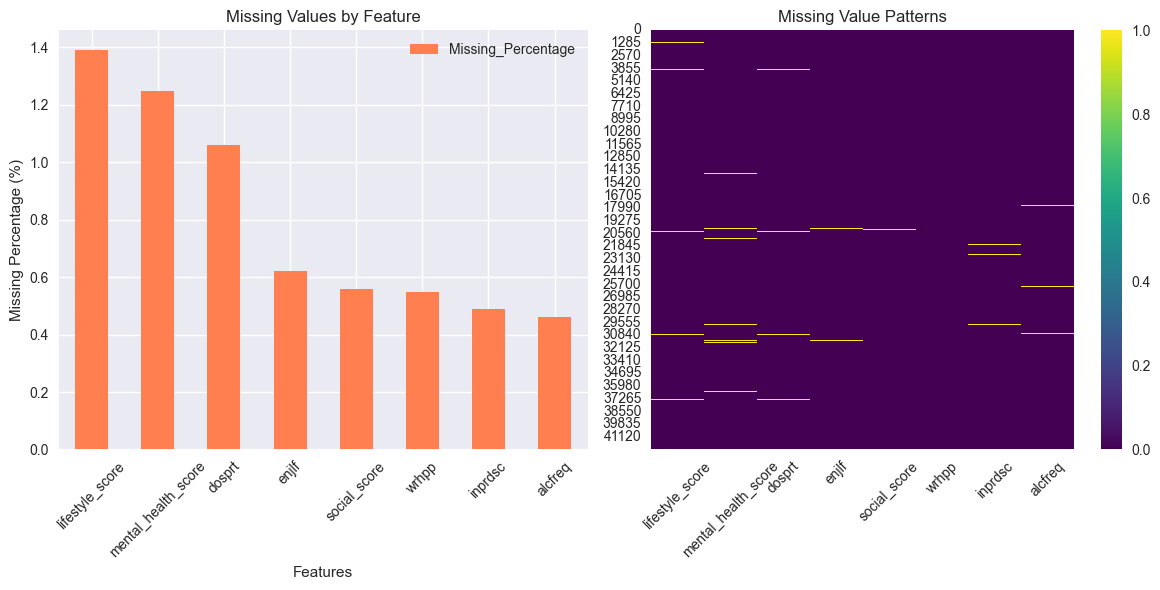


🔧 MISSING VALUE TREATMENT:
  happy: Filled 117 numerical values with median
  sclmeet: Filled 71 numerical values with median
  inprdsc: Filled 208 numerical values with median
  ctrlife: Filled 172 numerical values with median
  etfruit: Filled 93 numerical values with median
  eatveg: Filled 95 numerical values with median
  dosprt: Filled 451 numerical values with median
  cgtsmok: Filled 72 numerical values with median
  alcfreq: Filled 197 numerical values with median
  fltdpr: Filled 153 numerical values with median
  flteeff: Filled 146 numerical values with median
  slprl: Filled 113 numerical values with median
  wrhpp: Filled 233 numerical values with median
  fltlnl: Filled 168 numerical values with median
  enjlf: Filled 261 numerical values with median
  fltsd: Filled 169 numerical values with median
  lifestyle_score: Filled 590 numerical values with median
  social_score: Filled 236 numerical values with median
  mental_health_score: Filled 531 numerical values with med

In [5]:
# Comprehensive missing value analysis and treatment
print("🔍 MISSING VALUE ANALYSIS AND TREATMENT")
print("=" * 50)

# Analyze missing patterns
missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2),
    'Data_Type': df.dtypes
})

missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values(
    'Missing_Percentage', ascending=False)

if not missing_summary.empty:
    print(f"Columns with missing values ({len(missing_summary)} total):")
    display(missing_summary)
    
    # Visualize missing patterns
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    missing_summary.head(8).plot(x='Column', y='Missing_Percentage', 
                                 kind='bar', ax=plt.gca(), color='coral')
    plt.title('Missing Values by Feature')
    plt.xlabel('Features')
    plt.ylabel('Missing Percentage (%)')
    plt.xticks(rotation=45)
    
    # Missing value heatmap for correlation
    plt.subplot(1, 2, 2)
    missing_cols = missing_summary['Column'].tolist()[:8]
    if missing_cols:
        missing_matrix = df[missing_cols].isnull()
        sns.heatmap(missing_matrix, cbar=True, cmap='viridis')
        plt.title('Missing Value Patterns')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("✅ No missing values found in the dataset!")

# Handle missing values with appropriate strategies
print("\n🔧 MISSING VALUE TREATMENT:")

# Remove rows with missing target first
if 'hltprhc' in df.columns and df['hltprhc'].isnull().any():
    rows_before = len(df)
    df = df.dropna(subset=['hltprhc'])
    rows_after = len(df)
    print(f"✅ Removed {rows_before - rows_after} rows with missing target")

# Handle missing values by feature type
for col in df.columns:
    if col == 'hltprhc':  # Skip target
        continue
        
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        missing_pct = (missing_count / len(df)) * 100
        
        if df[col].dtype in ['object', 'category']:
            # Categorical: use mode
            mode_value = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
            df[col].fillna(mode_value, inplace=True)
            print(f"  {col}: Filled {missing_count} categorical values with mode '{mode_value}'")
        else:
            # Numerical: use median for low missing, consider removal for high missing
            if missing_pct < 5:
                df[col].fillna(df[col].median(), inplace=True)
                print(f"  {col}: Filled {missing_count} numerical values with median")
            elif missing_pct < 15:
                df[col].fillna(df[col].mean(), inplace=True)
                print(f"  {col}: Filled {missing_count} numerical values with mean")
            else:
                print(f"  ⚠️ {col}: High missing rate ({missing_pct:.1f}%) - consider removal")

print(f"\n✅ Missing value treatment completed")
print(f"Remaining missing values: {df.isnull().sum().sum()}")
print(f"Final dataset shape: {df.shape}")

---

## 📊 Outlier Detection and Treatment

📊 OUTLIER DETECTION AND TREATMENT
✅ happy: Capped 1620 outliers (3.8%)
   Range: 0.00-10.00 → 4.00-10.00
✅ ctrlife: Capped 478 outliers (1.1%)
   Range: 0.00-10.00 → 1.50-10.00
✅ fltdpr: Capped 701 outliers (1.7%)
   Range: 1.00-4.00 → 1.00-3.50
✅ flteeff: Capped 1467 outliers (3.5%)
   Range: 1.00-4.00 → 1.00-3.50
✅ slprl: Capped 1965 outliers (4.6%)
   Range: 1.00-4.00 → 1.00-3.50
✅ fltlnl: Capped 1045 outliers (2.5%)
   Range: 1.00-4.00 → 1.00-3.50
✅ fltsd: Capped 772 outliers (1.8%)
   Range: 1.00-4.00 → 1.00-3.50
✅ bmi: Capped 682 outliers (1.6%)
   Range: 16.00-40.00 → 16.00-36.59
✓ lifestyle_score: Few outliers (0.4%) - keeping as-is
✓ social_score: Few outliers (0.7%) - keeping as-is
✅ mental_health_score: Capped 895 outliers (2.1%)
   Range: 0.00-1.00 → 0.17-0.70

📊 OUTLIER ANALYSIS SUMMARY:


,Feature,Q1,Q3,IQR,Lower_Bound,Upper_Bound,Outlier_Count,Outlier_Percentage
0,happy,7.000000,9.000000,2.000000,4.000000,12.000000,1620,3.82
1,sclmeet,4.000000,6.000000,2.000000,1.000000,9.000000,0,0.00
2,inprdsc,2.000000,4.000000,2.000000,-1.000000,7.000000,0,0.00
3,ctrlife,6.000000,9.000000,3.000000,1.500000,13.500000,478,1.13
4,etfruit,2.000000,4.000000,2.000000,-1.000000,7.000000,0,0.00
5,eatveg,2.000000,4.000000,2.000000,-1.000000,7.000000,0,0.00
6,dosprt,0.000000,5.000000,5.000000,-7.500000,12.500000,0,0.00
7,cgtsmok,3.000000,6.000000,3.000000,-1.500000,10.500000,0,0.00
8,alcfreq,3.000000,7.000000,4.000000,-3.000000,13.000000,0,0.00
9,fltdpr,1.000000,2.000000,1.000000,-0.500000,3.500000,701,1.65


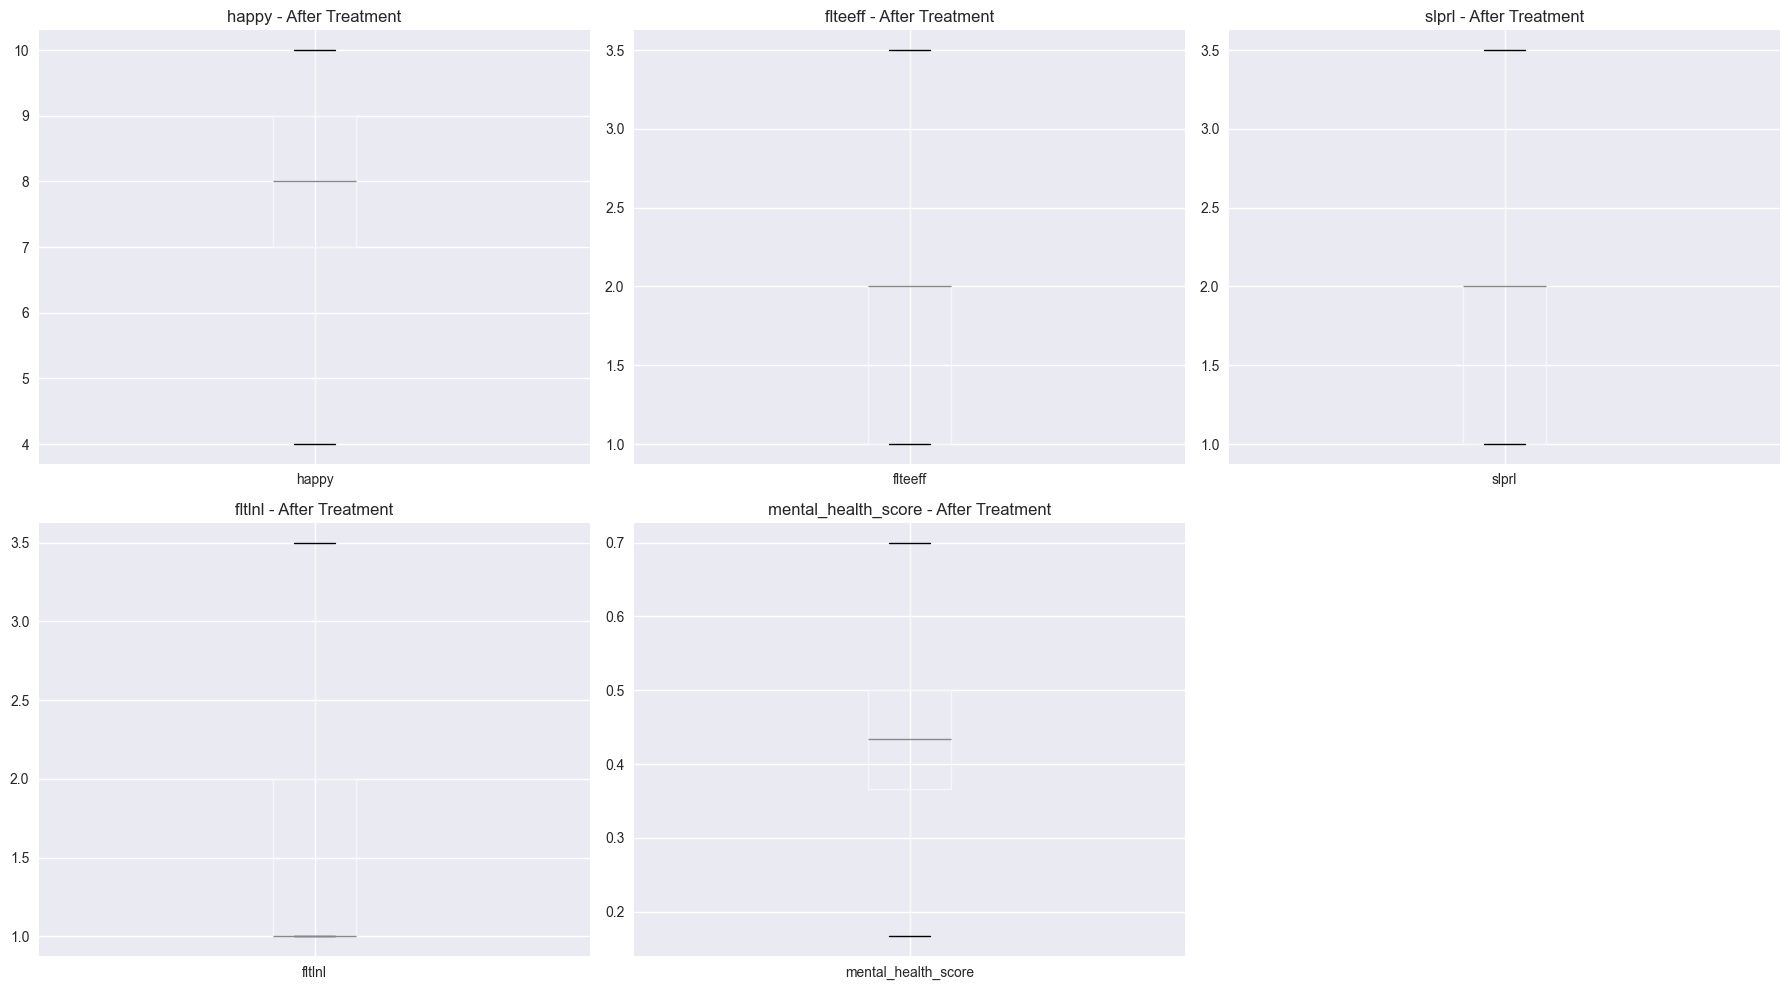


✅ Outlier treatment completed
Dataset shape after outlier treatment: (42377, 23)


In [6]:
# Outlier detection and treatment for numerical features
print("📊 OUTLIER DETECTION AND TREATMENT")
print("=" * 50)

# Update numerical features list
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
if 'hltprhc' in numerical_features:
    numerical_features.remove('hltprhc')

outlier_summary = []

# Analyze outliers for each numerical feature
for feature in numerical_features:
    if df[feature].notna().sum() < 10:  # Skip if too few values
        continue
        
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    if IQR == 0:  # Skip constant features
        continue
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(df)) * 100
    
    outlier_info = {
        'Feature': feature,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound,
        'Outlier_Count': outlier_count,
        'Outlier_Percentage': round(outlier_percentage, 2)
    }
    
    outlier_summary.append(outlier_info)
    
    # Apply outlier treatment based on percentage
    if outlier_percentage > 1 and outlier_percentage < 10:  # 1-10% outliers - cap them
        original_min, original_max = df[feature].min(), df[feature].max()
        df.loc[df[feature] < lower_bound, feature] = lower_bound
        df.loc[df[feature] > upper_bound, feature] = upper_bound
        new_min, new_max = df[feature].min(), df[feature].max()
        print(f"✅ {feature}: Capped {outlier_count} outliers ({outlier_percentage:.1f}%)")
        print(f"   Range: {original_min:.2f}-{original_max:.2f} → {new_min:.2f}-{new_max:.2f}")
    elif outlier_percentage >= 10:
        print(f"⚠️ {feature}: Many outliers ({outlier_percentage:.1f}%) - review manually")
    elif outlier_percentage > 0:
        print(f"✓ {feature}: Few outliers ({outlier_percentage:.1f}%) - keeping as-is")

if outlier_summary:
    outlier_df = pd.DataFrame(outlier_summary)
    print(f"\n📊 OUTLIER ANALYSIS SUMMARY:")
    display(outlier_df)
    
    # Visualize outlier patterns for features with significant outliers
    high_outlier_features = [item['Feature'] for item in outlier_summary 
                            if item['Outlier_Percentage'] > 2]
    
    if high_outlier_features:
        n_plots = min(6, len(high_outlier_features))
        if n_plots > 0:
            fig, axes = plt.subplots(2, 3, figsize=(18, 10))
            axes = axes.ravel() if n_plots > 1 else [axes]
            
            for idx, feature in enumerate(high_outlier_features[:n_plots]):
                df.boxplot(column=feature, ax=axes[idx])
                axes[idx].set_title(f'{feature} - After Treatment')
            
            # Hide empty subplots
            for idx in range(n_plots, len(axes)):
                axes[idx].set_visible(False)
            
            plt.tight_layout()
            plt.show()

print(f"\n✅ Outlier treatment completed")
print(f"Dataset shape after outlier treatment: {df.shape}")

---

## 🔤 Feature Encoding and Transformation

In [7]:
# Feature encoding and transformation
print("🔤 FEATURE ENCODING AND TRANSFORMATION")
print("=" * 50)

# Update feature lists after cleaning
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target from feature lists
if 'hltprhc' in numerical_features:
    numerical_features.remove('hltprhc')
if 'hltprhc' in categorical_features:
    categorical_features.remove('hltprhc')

print(f"Features to encode:")
print(f"  Numerical: {len(numerical_features)} features")
print(f"  Categorical: {len(categorical_features)} features")

# Prepare for encoding
df_encoded = df.copy()

# Handle categorical features
encoded_feature_names = []

if categorical_features:
    for col in categorical_features:
        unique_count = df[col].nunique()
        print(f"\n{col}: {unique_count} unique values")
        
        if unique_count == 2:  # Binary categorical
            # Label encode binary variables
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df[col].astype(str))
            print(f"  ✅ Label encoded (binary)")
            encoded_feature_names.append(col)
            
        elif unique_count <= 10:  # Low cardinality - one-hot encode
            # One-hot encode
            encoded_cols = pd.get_dummies(df[col], prefix=col, dummy_na=True)
            df_encoded = pd.concat([df_encoded, encoded_cols], axis=1)
            df_encoded.drop(columns=[col], inplace=True)
            print(f"  ✅ One-hot encoded ({len(encoded_cols.columns)} new columns)")
            encoded_feature_names.extend(encoded_cols.columns.tolist())
            
        else:  # High cardinality - label encode
            print(f"  ⚠️ High cardinality - label encoding")
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df[col].astype(str))
            print(f"  ✅ Label encoded (high cardinality)")
            encoded_feature_names.append(col)

print(f"\n📊 After encoding: {df_encoded.shape}")

# Update final feature lists
final_features = [col for col in df_encoded.columns if col != 'hltprhc']
print(f"Final feature count: {len(final_features)}")
print(f"Feature types after encoding:")
print(f"  Original numerical: {len(numerical_features)}")
print(f"  Encoded features: {len(encoded_feature_names)}")
print(f"  Total features: {len(final_features)}")

🔤 FEATURE ENCODING AND TRANSFORMATION
Features to encode:
  Numerical: 22 features
  Categorical: 0 features

📊 After encoding: (42377, 23)
Final feature count: 22
Feature types after encoding:
  Original numerical: 22
  Encoded features: 0
  Total features: 22


In [8]:
# Feature scaling and normalization
print("📏 FEATURE SCALING AND NORMALIZATION")
print("=" * 50)

# Separate features and target
X = df_encoded[final_features]
y = df_encoded['hltprhc']

print(f"Features matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Identify numerical vs encoded categorical features
numerical_cols = numerical_features.copy()
categorical_encoded_cols = [col for col in final_features if col not in numerical_features]

print(f"\nFeature groups for scaling:")
print(f"  Numerical features: {len(numerical_cols)}")
print(f"  Encoded categorical: {len(categorical_encoded_cols)}")

# Scale numerical features
scaler = StandardScaler()
X_scaled = X.copy()

if numerical_cols:
    print(f"\nScaling numerical features...")
    X_scaled[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    
    # Show scaling statistics
    print(f"Scaling statistics (first 5 numerical features):")
    for col in numerical_cols[:5]:
        mean_val = X_scaled[col].mean()
        std_val = X_scaled[col].std()
        print(f"  {col}: μ={mean_val:.3f}, σ={std_val:.3f}")
        
print(f"\n✅ Feature scaling completed")
print(f"Scaled features shape: {X_scaled.shape}")

# Quick scaling validation
if len(numerical_cols) > 0:
    numerical_means = X_scaled[numerical_cols].mean()
    numerical_stds = X_scaled[numerical_cols].std()
    print(f"\nScaling validation:")
    print(f"  Numerical means close to 0: {(np.abs(numerical_means) < 0.01).all()}")
    print(f"  Numerical stds close to 1: {(np.abs(numerical_stds - 1) < 0.01).all()}")

📏 FEATURE SCALING AND NORMALIZATION
Features matrix shape: (42377, 22)
Target vector shape: (42377,)
Target distribution: {0: 37582, 1: 4795}

Feature groups for scaling:
  Numerical features: 22
  Encoded categorical: 0

Scaling numerical features...
Scaling statistics (first 5 numerical features):
  happy: μ=-0.000, σ=1.000
  sclmeet: μ=0.000, σ=1.000
  inprdsc: μ=-0.000, σ=1.000
  ctrlife: μ=-0.000, σ=1.000
  etfruit: μ=-0.000, σ=1.000

✅ Feature scaling completed
Scaled features shape: (42377, 22)

Scaling validation:
  Numerical means close to 0: True
  Numerical stds close to 1: True


In [9]:
# Train-validation-test split with stratification
print("🎯 TRAIN-VALIDATION-TEST SPLIT")
print("=" * 50)

# Check current class distribution
class_dist = y.value_counts(normalize=True)
print(f"Overall class distribution:")
for class_val, prop in class_dist.items():
    print(f"  Class {class_val}: {prop:.3f} ({prop*100:.1f}%)")

# First split: train+val (80%) vs test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Second split: train (60% of total) vs validation (20% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,  # 0.25 of 0.8 = 0.2 of total
    random_state=42,
    stratify=y_temp
)

print(f"\nData splits:")
print(f"  Training: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"  Validation: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"  Test: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")

# Verify stratification
def check_stratification(y_split, split_name):
    dist = y_split.value_counts(normalize=True)
    print(f"  {split_name}:")
    for class_val in sorted(dist.index):
        print(f"    Class {class_val}: {dist[class_val]:.3f} ({dist[class_val]*100:.1f}%)")

print(f"\nClass distribution verification:")
check_stratification(y_train, "Training")
check_stratification(y_val, "Validation")
check_stratification(y_test, "Test")

print(f"\n✅ Stratified splits created successfully")
print(f"Features in each split: {X_train.shape[1]} features")

🎯 TRAIN-VALIDATION-TEST SPLIT
Overall class distribution:
  Class 0: 0.887 (88.7%)
  Class 1: 0.113 (11.3%)

Data splits:
  Training: 25,425 samples (60.0%)
  Validation: 8,476 samples (20.0%)
  Test: 8,476 samples (20.0%)

Class distribution verification:
  Training:
    Class 0: 0.887 (88.7%)
    Class 1: 0.113 (11.3%)
  Validation:
    Class 0: 0.887 (88.7%)
    Class 1: 0.113 (11.3%)
  Test:
    Class 0: 0.887 (88.7%)
    Class 1: 0.113 (11.3%)

✅ Stratified splits created successfully
Features in each split: 22 features


In [12]:
# Save processed datasets and preprocessing artifacts
print("💾 SAVING PROCESSED DATA AND ARTIFACTS")
print("=" * 50)

# Create output directory
processed_dir = "../data/processed"
os.makedirs(processed_dir, exist_ok=True)

# 1. Save train/validation/test splits as CSV files
datasets_to_save = {
    'train.csv': (pd.concat([X_train, y_train], axis=1), 'Training set'),
    'validation.csv': (pd.concat([X_val, y_val], axis=1), 'Validation set'),
    'test.csv': (pd.concat([X_test, y_test], axis=1), 'Test set')
}

for filename, (data, description) in datasets_to_save.items():
    filepath = os.path.join(processed_dir, filename)
    data.to_csv(filepath, index=False)
    print(f"✅ Saved {description}: {filepath} ({data.shape})")

# 2. Save the complete processed dataset
complete_processed = pd.concat([X_scaled, y], axis=1)
complete_filepath = os.path.join(processed_dir, 'health_clean.csv')
complete_processed.to_csv(complete_filepath, index=False)
print(f"✅ Saved complete processed dataset: {complete_filepath} ({complete_processed.shape})")

# 3. Save feature names and metadata
feature_info = {
    'all_features': final_features,
    'numerical_features': numerical_cols,
    'categorical_encoded_features': categorical_encoded_cols,
    'target_variable': 'hltprhc',
    'total_features': len(final_features),
    'total_samples': len(complete_processed)
}

feature_names_df = pd.DataFrame({
    'feature_name': final_features,
    'feature_type': ['numerical' if f in numerical_cols else 'categorical_encoded' for f in final_features]
})
feature_names_path = os.path.join(processed_dir, 'feature_names.csv')
feature_names_df.to_csv(feature_names_path, index=False)
print(f"✅ Saved feature names: {feature_names_path}")

# 4. Save preprocessing artifacts (scaler, split info)
artifacts = {
    'scaler': scaler,
    'feature_info': feature_info,
    'split_info': {
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test),
        'random_state': 42
    }
}

artifacts_path = os.path.join(processed_dir, 'preprocessing_artifacts.joblib')
joblib.dump(artifacts, artifacts_path)
print(f"✅ Saved preprocessing artifacts: {artifacts_path}")

print(f"\n📊 PREPROCESSING SUMMARY")
print(f"=" * 50)
print(f"Original dataset: {df.shape}")
print(f"Processed dataset: {complete_processed.shape}")
print(f"Features after processing: {len(final_features)}")
print(f"Training samples: {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")
print(f"Test samples: {len(X_test):,}")
print(f"\n✅ Data preprocessing completed successfully!")
print(f"🎯 Ready for model training and evaluation")

💾 SAVING PROCESSED DATA AND ARTIFACTS
✅ Saved Training set: ../data/processed/train.csv ((25425, 23))
✅ Saved Validation set: ../data/processed/validation.csv ((8476, 23))
✅ Saved Test set: ../data/processed/test.csv ((8476, 23))
✅ Saved complete processed dataset: ../data/processed/health_clean.csv ((42377, 23))
✅ Saved feature names: ../data/processed/feature_names.csv
✅ Saved preprocessing artifacts: ../data/processed/preprocessing_artifacts.joblib

📊 PREPROCESSING SUMMARY
Original dataset: (42377, 23)
Processed dataset: (42377, 23)
Features after processing: 22
Training samples: 25,425
Validation samples: 8,476
Test samples: 8,476

✅ Data preprocessing completed successfully!
🎯 Ready for model training and evaluation
